In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
from scipy import stats # Import the stats module from SciPy

from models import construct_model

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
# --- 2. Data Pipeline ---
def get_mnist_loaders(batch_size):
    """Prepares the MNIST train, validation, and test data loaders."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

In [4]:
def corrupt_images(images, corruption_fraction):
    """
    Corrupts a batch of images by REPLACING a fraction of pixels with random noise.
    Args:
        images (torch.Tensor): A batch of images (B, C, H, W).
        corruption_fraction (float): The fraction of pixels to corrupt (0.0 to 1.0).
    Returns:
        torch.Tensor: The batch of corrupted images.
    """
    if corruption_fraction == 0.0:
        return images

    corrupted_images = images.clone()
    batch_size, _, height, width = images.shape
    num_pixels_total = height * width
    num_pixels_to_corrupt = int(corruption_fraction * num_pixels_total)

    for i in range(batch_size):
        # Generate a random permutation of pixel indices to corrupt
        indices = torch.randperm(num_pixels_total, device=images.device)[:num_pixels_to_corrupt]

        # Convert flat indices to 2D indices
        row_indices = indices // width
        col_indices = indices % width

        # --- Generate random pixel values to replace the existing ones ---
        # Values are from a uniform distribution across the full [-1, 1] range.
        random_pixels = torch.rand(num_pixels_to_corrupt, device=images.device) * 2 - 1

        # --- Place the new random pixels into the image ---
        corrupted_images[i, 0, row_indices, col_indices] = random_pixels

    return corrupted_images

In [28]:
def analyze_with_individual_corruption(data_rater, data_loader, num_batches=5, current_step=None):
    """
    Analyzes the DataRater by corrupting each image with a continuous random
    fraction and creating a scatter plot of scores vs. corruption.
    """
    print(f"\n--- Analyzing with Continuous Individual Corruption over {num_batches} batches --- MetaStep: {current_step}")
    data_rater.eval()  # Set the model to evaluation mode

    # These master lists will store the results from all batches
    all_scores = []
    all_fractions = []

    # Loop over the specified number of batches
    for i, (batch_images, _) in enumerate(data_loader):
        if i >= num_batches:
            break

        batch_images = batch_images.to(DEVICE)
        batch_size = batch_images.size(0)

        individually_corrupted_batch = torch.zeros_like(batch_images)
        fractions_for_this_batch = []

        # Corrupt each image in the batch one by one
        for j in range(batch_size):
            # --- NEW: Generate a continuous random fraction between 0.0 and 1.0 ---
            frac = np.random.uniform(0.0, 1.0)
            fractions_for_this_batch.append(frac)

            # Corrupt the single image (note: we keep the batch dimension)
            original_image = batch_images[j:j+1]
            corrupted_image = corrupt_images(original_image, frac)
            individually_corrupted_batch[j] = corrupted_image

        # Get the model's scores for the entire batch of individually corrupted images
        with torch.no_grad():
            scores = data_rater(individually_corrupted_batch)
            weights = scores

        # Append the results to our master lists
        all_scores.extend(weights.cpu().numpy())
        all_fractions.extend(fractions_for_this_batch)

    # --- Plotting and Regression Analysis ---

    plt.figure(figsize=(12, 8))

    # Scatter plot with continuous x-axis values (jitter is no longer needed)
    plt.scatter(all_fractions, all_scores, alpha=0.3, label='Individual Image Score')

    # Perform and plot the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_fractions, all_scores)
    r_squared = r_value**2

    x_line = np.array([min(all_fractions), max(all_fractions)])
    y_line = slope * x_line + intercept

    plt.plot(x_line, y_line,
             color='red', linewidth=2,
             label=f'Linear Regression (R² = {r_squared:.3f})')

    plt.title('DataRater Score vs. Individual Image Corruption', fontsize=16)
    plt.xlabel('Fraction of Corrupted Pixels')
    plt.ylabel('Raw Score (Rating)')
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.show()

In [30]:
test_loader = get_mnist_loaders(128)

In [31]:
def load_data_rater_from_checkpoint(checkpoint_path, device='cpu'):
    """
    Load DataRater model using the existing construct_model function.
    """
    # Create model using the same constructor as training
    model = construct_model('DataRater')
    
    # Load the saved state dictionary
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Load the state dict into the model
    model.load_state_dict(state_dict)
    
    # Set to evaluation mode and move to device
    model.eval()
    model = model.to(device)
    
    return model


--- Analyzing with Continuous Individual Corruption over 100 batches --- MetaStep: None


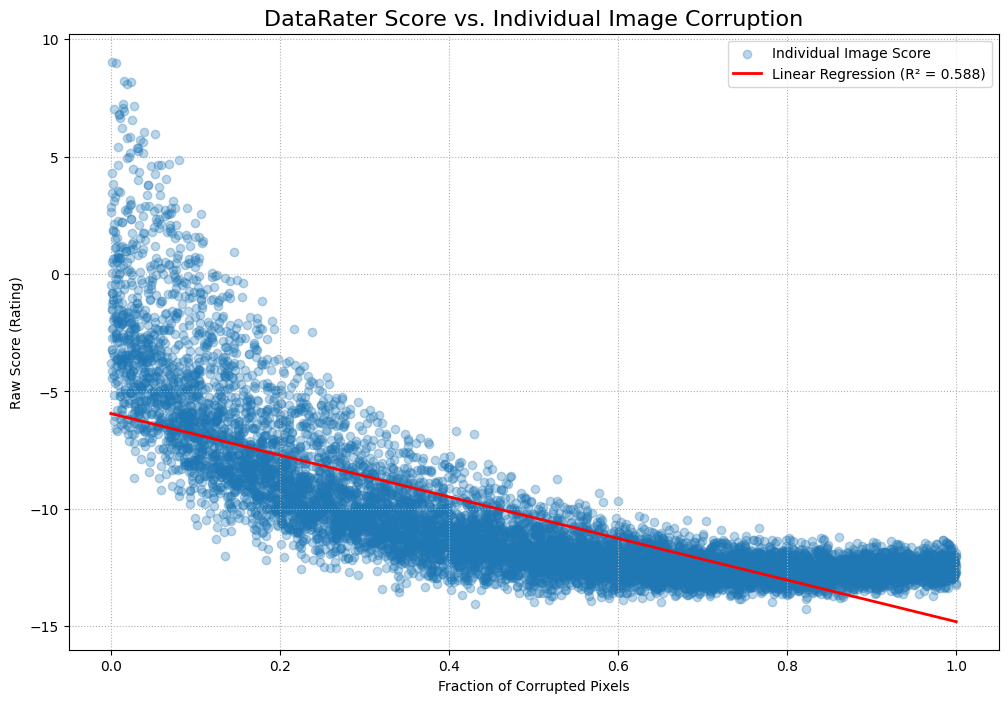

In [32]:
checkpoint_path = "experiments/mnist_20250919_0815_53175f5e/data_rater.pt"  # Update this path

trained_data_rater = load_data_rater_from_checkpoint(checkpoint_path, DEVICE)
analyze_with_individual_corruption(trained_data_rater, test_loader, num_batches=100)


--- Visualizing Image Corruption with DataRater Scores ---


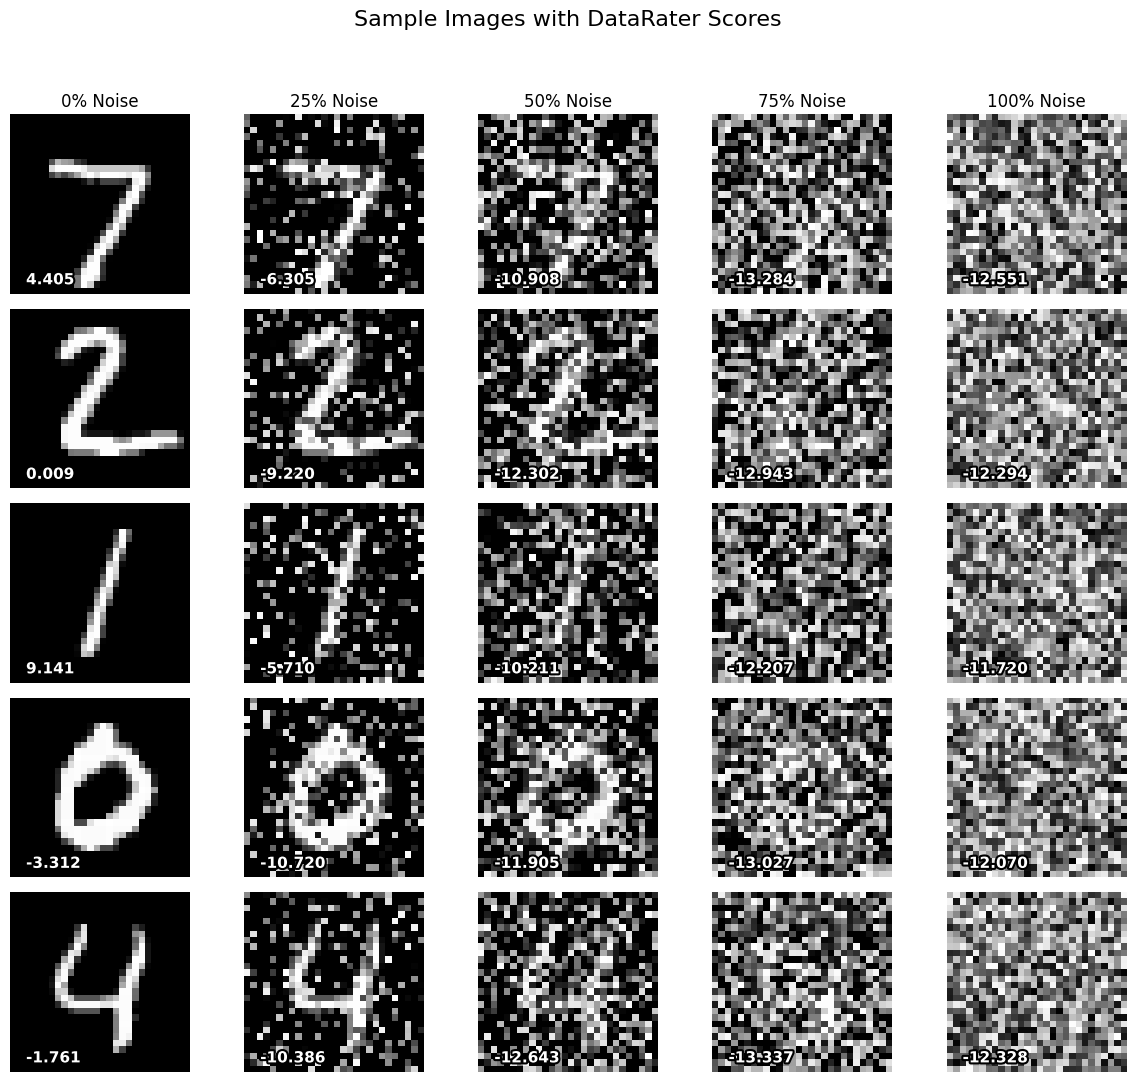

In [33]:
visualize_corruption(trained_data_rater, test_loader, num_images=5)